In [1]:
from msdm.domains import GridWorld
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.core.problemclasses.mdp import TabularPolicy
from algorithms import MaxLikelihoodIRL
import torch
from frozendict import frozendict
from dataset import TrajectoryDataset
import matplotlib.pyplot as plt

# Corresponds to supervised_irl_example1 w/ epochs=10, batch_size=128, 100000 trajectories, lr=0.1, weight_decay=0.0001, momentum=0.9

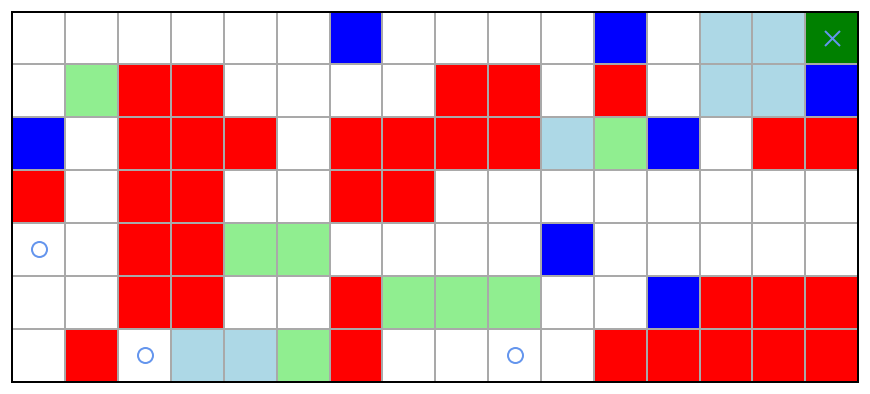

In [2]:
# Create a gridworld
mdp = GridWorld(
    tile_array=[
        "......c....c.bbg",
        ".axx....xx.x.bbc",
        "c.xxx.xxxxbac.xx",
        "x.xx..xx........",
        "s.xxaa....c.....",
        "..xx..xaaa..cxxx",
        ".xsbbax..s.xxxxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=0.99,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
mdp.plot(featurecolors=featurecolors)


In [3]:
# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([3.9]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)


In [4]:
# Generate gen_iters of trajectories
gen_iters = 10000
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

trajs_dataset = TrajectoryDataset(trajectories)

In [5]:
def featurizer(state, action, next_state):
  feature_name = mdp.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}

def fixed_reward(state, action, next_state):
  return mdp.step_cost

In [6]:
algorithm = MaxLikelihoodIRL(mdp, featurizer, fixed_reward, batch_size=128, epochs=10, lr=1, momentum=0.9, entropy_weight=3.9)
learned_weights, the_policy, losses = algorithm.learn(trajs_dataset)

Using cpu
Inital reward weights: tensor([-1.5167,  0.0860, -1.5815, -0.5643], dtype=torch.float64)

loss: 0.542431  [    0/10000]
loss: 0.454831  [    0/10000]
loss: 0.483832  [    0/10000]
loss: 0.453058  [    0/10000]
loss: 0.490570  [    0/10000]
loss: 0.470804  [    0/10000]
loss: 0.483228  [    0/10000]
loss: 0.490154  [    0/10000]
loss: 0.493678  [    0/10000]
loss: 0.487238  [    0/10000]
Final reward weights: tensor([ -0.1810,  -0.1436,  -4.7693, -14.0067], dtype=torch.float64,
       requires_grad=True)



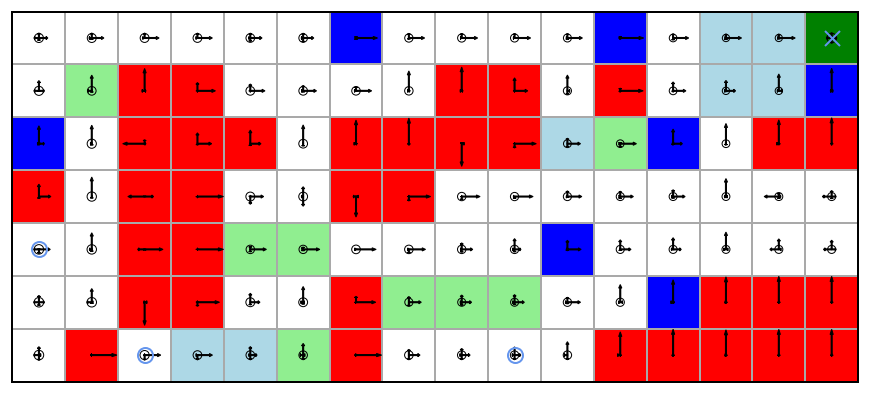

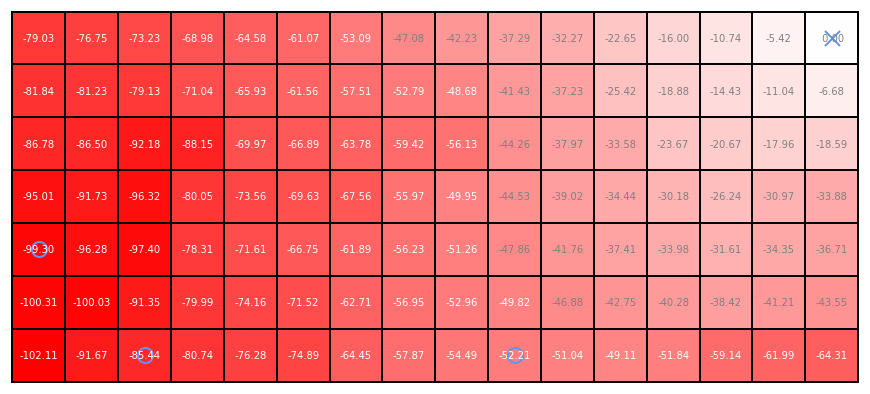

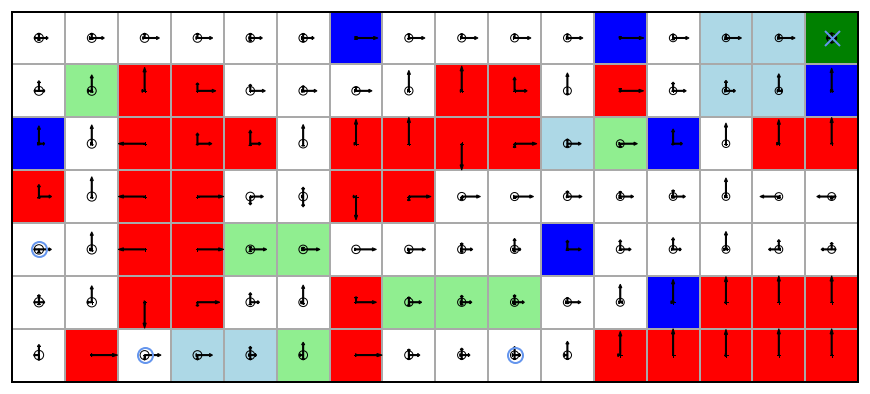

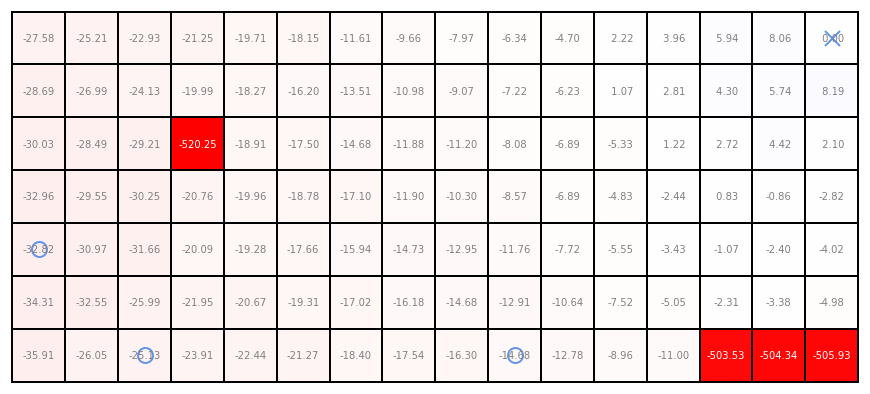

In [7]:
# solve with matrices returned by gridworld object
my_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=the_policy.policy.detach().numpy()
)

my_state_values = dict(zip(mdp.state_list, the_policy.state_values.detach()))
mdp.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp.plot().plot_state_map(my_state_values)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_policy.evaluate_on(mdp).V)


In [8]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp).initial_value}")


Learned policy's initial value: -90.0065730845524
Expert's policy initial value: -24.209351693872225


In [9]:
expert_policy.evaluate_on(mdp).V

{frozendict({'x': -1, 'y': -1}): 0.0,
 frozendict({'x': 0, 'y': 0}): -35.91329301039348,
 frozendict({'x': 0, 'y': 1}): -34.31293847964372,
 frozendict({'x': 0, 'y': 2}): -32.82171721872216,
 frozendict({'x': 0, 'y': 3}): -32.95986222430787,
 frozendict({'x': 0, 'y': 4}): -30.02875620319386,
 frozendict({'x': 0, 'y': 5}): -28.692096531992945,
 frozendict({'x': 0, 'y': 6}): -27.57832314181115,
 frozendict({'x': 1, 'y': 0}): -26.054713193697076,
 frozendict({'x': 1, 'y': 1}): -32.55277675684414,
 frozendict({'x': 1, 'y': 2}): -30.968796462538506,
 frozendict({'x': 1, 'y': 3}): -29.547061749334556,
 frozendict({'x': 1, 'y': 4}): -28.493466630959986,
 frozendict({'x': 1, 'y': 5}): -26.9869992011605,
 frozendict({'x': 1, 'y': 6}): -25.212491858460346,
 frozendict({'x': 2, 'y': 0}): -25.126965060012495,
 frozendict({'x': 2, 'y': 1}): -25.985587474711014,
 frozendict({'x': 2, 'y': 2}): -31.65910849791312,
 frozendict({'x': 2, 'y': 3}): -30.25159113184121,
 frozendict({'x': 2, 'y': 4}): -29.20

In [10]:
print(losses)

[0.054283685982227325, 0.0592983178794384, 0.05714781582355499, 0.052503008395433426, 0.060192570090293884, 0.059561699628829956, 0.05921351537108421, 0.05436045676469803, 0.048523157835006714, 0.05497867986559868]


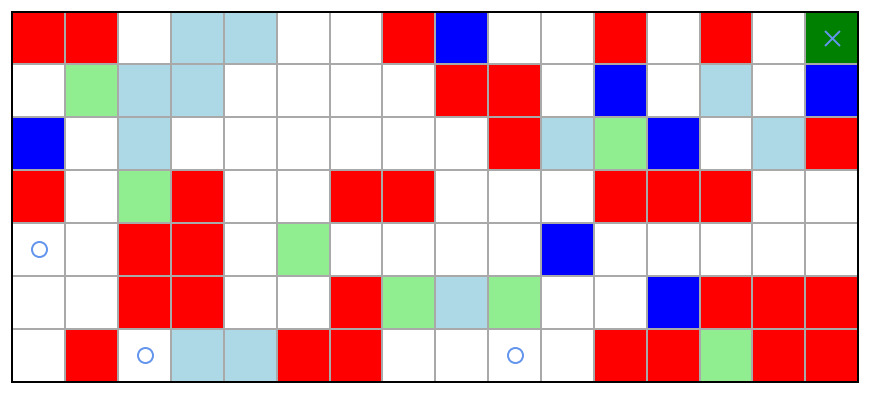

In [11]:
# Create a gridworld
mdp2 = GridWorld(
    tile_array=[
        "xx.bb..xc..x.x.g",
        ".abb....xx.c.b.c",
        "c.b......xbac.bx",
        "x.ax..xx...xxx..",
        "s.xx.a....c.....",
        "..xx..xaba..cxxx",
        ".xsbbxx..s.xxaxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=0.99,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
mdp2.plot(featurecolors=featurecolors)


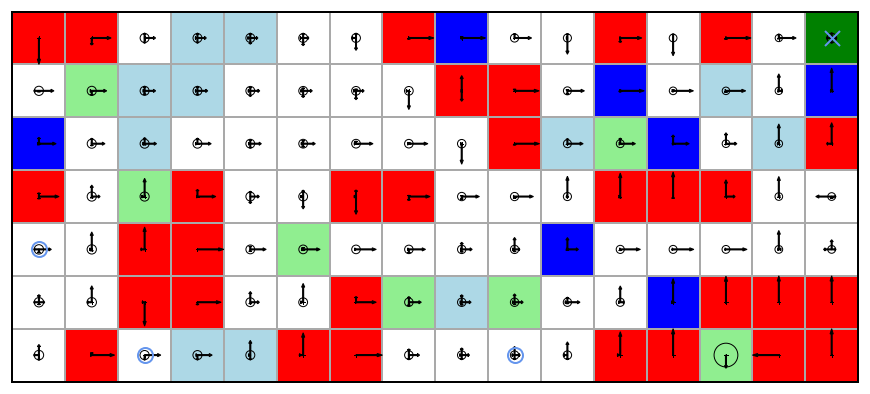

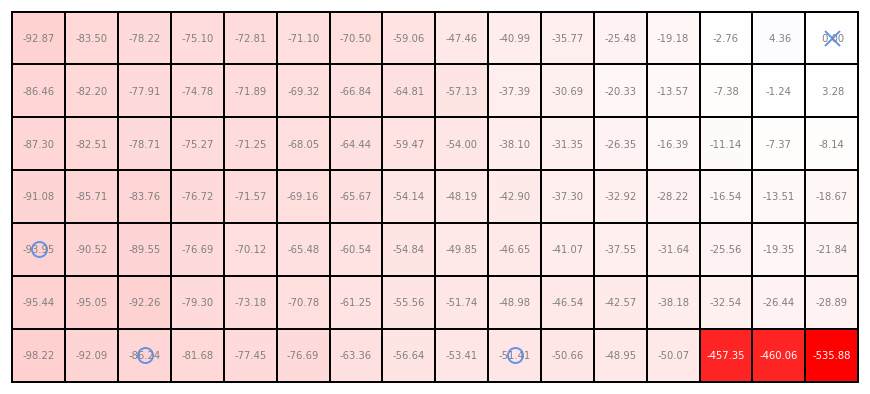

In [12]:
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([3.9]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp2.state_list, expert_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [13]:
def featurizer(state, action, next_state):
  feature_name = mdp2.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}


def fixed_reward(state, action, next_state):
  return mdp2.step_cost


In [14]:
algorithm2 = MaxLikelihoodIRL(mdp2, featurizer, fixed_reward, batch_size=128, epochs=10, lr=1, weight_decay=0.0001, momentum=0.9, entropy_weight=3.9)

# compute policy from learned weights
feature_reward_matrix2 = torch.einsum(
    "sanf,f->san",
    algorithm2.get_feature_matrix(),
    learned_weights
)

reward_matrix2 = feature_reward_matrix2 + algorithm2.get_fixed_reward_matrix()
terminal_index = mdp2.state_index.get(
    frozendict({'x': -1, 'y': -1}))
reward_matrix2[:, :, terminal_index] = 0

my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=reward_matrix2,
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([3.9]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


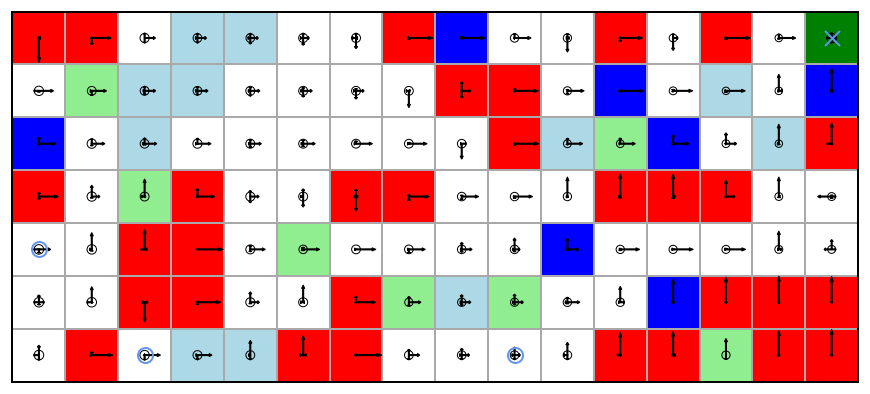

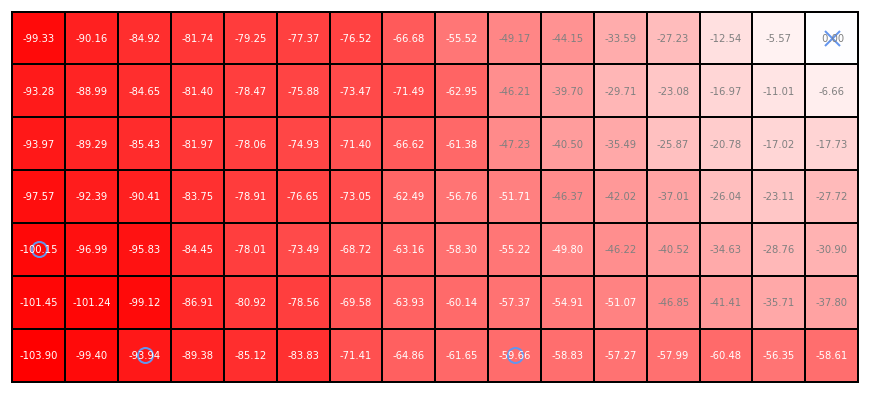

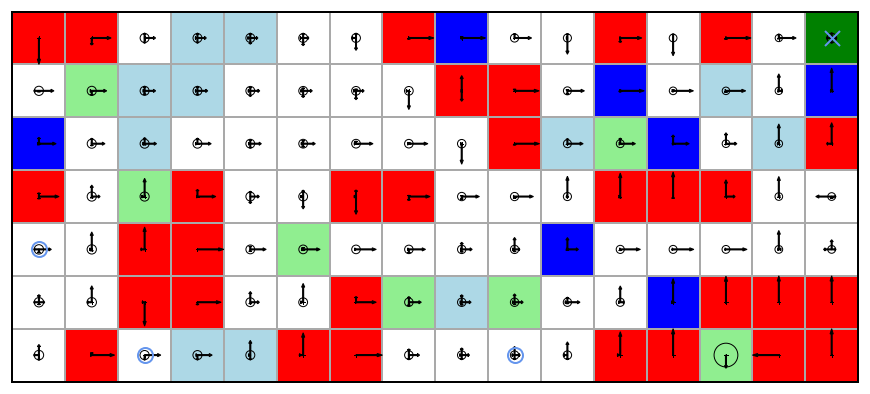

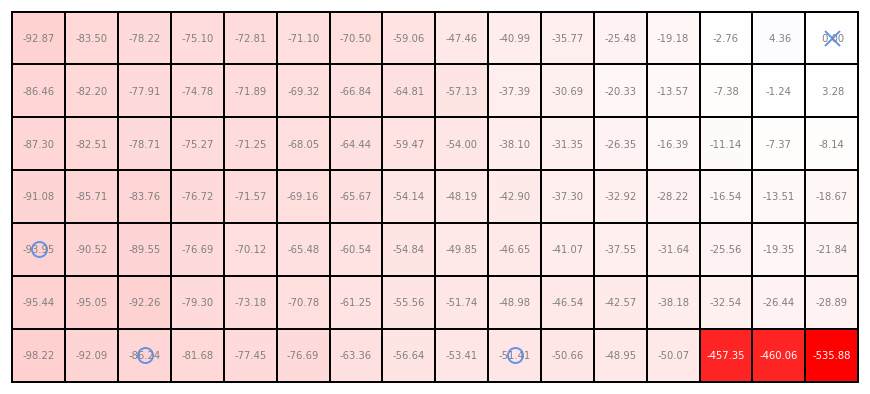

In [15]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)

my_state_values = dict(zip(mdp2.state_list, my_erpi.state_values.detach()))
mdp2.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp2.plot().plot_state_map(my_state_values)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [16]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp2).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp2).initial_value}")


Learned policy's initial value: -132.59683246089497
Expert's policy initial value: -24.020097779956245
